# Tile 70500 20200303
Prepare target IDs of objects in Tile 705000 observed on March 3, 2020 for visual inspection. Examine the $\chi^2-\Delta\chi^2$ relation and select targets that require VI (e.g. $\Delta \chi^2 < 100$). Also include the same number of objects outside of the criteria so we don't only select poor spectra

In [1]:
import os
import glob
import fitsio
import numpy as np 

from desitarget.cmx import cmx_targetmask

In [2]:
# -- plotting -- 
import matplotlib as mpl
import matplotlib.pyplot as plt
#mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False

In [3]:
dir_tile = '/global/cfs/cdirs/desi/spectro/redux/andes/tiles/70500' # Andes reduction

Lets read in the redrock files for the combined exposures

In [4]:
# get all the petals
petals = np.unique([int(fzbest.split('-')[1]) for fzbest in glob.glob(os.path.join(dir_tile, '20200303', 'zbest-*-70500-20200303.fits'))])

targids, zwarns, chi2s, dchi2s = [], [], [], []
# loop through petals
for petal in petals: 
    f_coadd = os.path.join(dir_tile, '20200303', 'coadd-%i-70500-20200303.fits' % petal)
    coadd = fitsio.read(f_coadd)

    fzbest = os.path.join(dir_tile, '20200303', 'zbest-%i-70500-20200303.fits' % petal)
    zbest = fitsio.read(fzbest)

    # only keep BGS targets
    is_BGS  = (coadd['CMX_TARGET'] & cmx_targetmask.cmx_mask.mask('SV0_BGS')) != 0
    gal_cut = np.ones(len(coadd['CMX_TARGET'])).astype(bool)

    targids.append(zbest['TARGETID'][gal_cut])
    zwarns.append(zbest['ZWARN'][gal_cut])

    chi2s.append(zbest['CHI2'][gal_cut])
    dchi2s.append(zbest['DELTACHI2'][gal_cut])

targids = np.concatenate(targids)
zwarns = np.concatenate(zwarns)

chi2s = np.concatenate(chi2s)
dchi2s = np.concatenate(dchi2s)

rrflag = (zwarns != 0) 
dchi2cut = (dchi2s < 1000)

2000 total BGS targets
660 targets with (dchi2 < 500)
574 targets with (dchi2 < 500) and (ZWARN == 0)


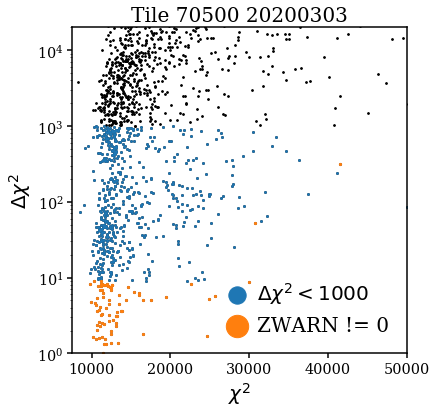

In [5]:
print('%i total BGS targets' % len(chi2s))
    
fig = plt.figure(figsize=(6, 6))
sub = fig.add_subplot(111)

sub.scatter(chi2s, dchi2s, s=3, c='k')
sub.scatter(chi2s[dchi2cut], dchi2s[dchi2cut], s=3, c='C0', label='$\Delta \chi^2 < 1000$')
sub.scatter(chi2s[rrflag], dchi2s[rrflag], s=5, c='C1', label='ZWARN != 0')

sub.legend(loc='lower right', fontsize=20, markerscale=10, handletextpad=0)
sub.set_xlabel(r'$\chi^2$', fontsize=20)
sub.set_xlim(7500., 50000)
sub.set_ylabel(r'$\Delta \chi^2$', fontsize=20)
sub.set_ylim(1., 2e4)
sub.set_yscale('log')
sub.set_title('Tile 70500 20200303', fontsize=20)

print('%i targets with (dchi2 < 500)' % np.sum(dchi2cut))
print('%i targets with (dchi2 < 500) and (ZWARN == 0)' % np.sum(dchi2cut & ~rrflag))

Lets select targets with $\Delta \chi^2 < 1000$ that are not flagged by redrock. Remarkably, redrock flags almost everything with $\Delta \chi^2 < 10$. We'll also sprinkle in ~126 other random targets

In [6]:
vi_targs = np.concatenate([np.arange(len(targids))[dchi2cut & ~rrflag], np.random.choice(np.arange(len(targids))[~(dchi2cut & ~rrflag)], 126, replace=False)])

Text(0.5,1,'Tile 70500 20200303')

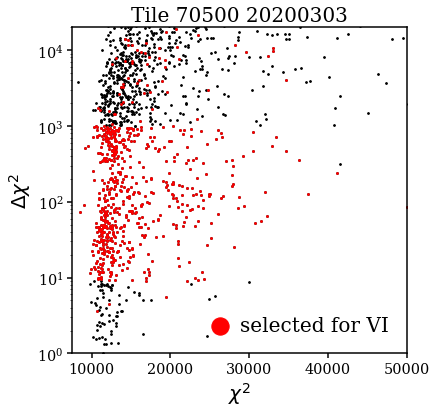

In [7]:
fig = plt.figure(figsize=(6, 6))
sub = fig.add_subplot(111)

sub.scatter(chi2s, dchi2s, s=3, c='k')
sub.scatter(chi2s[vi_targs], dchi2s[vi_targs], s=3, c='r', label='selected for VI')

sub.legend(loc='lower right', fontsize=20, markerscale=10, handletextpad=0)
sub.set_xlabel(r'$\chi^2$', fontsize=20)
sub.set_xlim(7500., 50000)
sub.set_ylabel(r'$\Delta \chi^2$', fontsize=20)
sub.set_ylim(1., 2e4)
sub.set_yscale('log')
sub.set_title('Tile 70500 20200303', fontsize=20)

In [8]:
np.savetxt('tile70500-20200303-vi-targetids.dat', targids[vi_targs], fmt='%i')